<a href="https://colab.research.google.com/github/8sheeta8/2025_Capstone_DDoS-Botnet/blob/main/CNN%2BTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==========================
# 1. 필요한 라이브러리 임포트
# ==========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models
import tensorflow as tf

print("[1단계 완료] 라이브러리 임포트 완료")

[1단계 완료] 라이브러리 임포트 완료


In [3]:
# ==========================
# 2. 데이터 불러오기 및 통합
# ==========================
csv_files = [
    '/content/Tuesday-WorkingHours.pcap_ISCX.csv',
    '/content/Wednesday-workingHours.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'
]

full_data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
full_data.columns = full_data.columns.str.strip()  # 컬럼명 공백 제거

print("[2단계 완료] 데이터 통합 완료")
print("전체 데이터 shape:", full_data.shape)

[2단계 완료] 데이터 통합 완료
전체 데이터 shape: (2300825, 79)


In [5]:
print(full_data.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [11]:
csv_files = [
    '/content/Tuesday-WorkingHours.pcap_ISCX.csv',
    '/content/Wednesday-workingHours.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'
]

for file in csv_files:
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()   # ★ 컬럼명 앞뒤 공백 제거 ★
    labels = df['Label'].unique()
    print(f"\n{file} 파일에 포함된 라벨 종류:")
    print(labels)



/content/Monday-WorkingHours.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN']

/content/Tuesday-WorkingHours.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'FTP-Patator' 'SSH-Patator']

/content/Wednesday-workingHours.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']

/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']

/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'Infiltration']

/content/Friday-WorkingHours-Morning.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'Bot']

/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'DDoS']

/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'PortScan']


In [4]:

# ==========================
# 3. 데이터 전처리
# ==========================
# 불필요한 컬럼 제거
drop_columns = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp']
full_data = full_data.drop(columns=[col for col in drop_columns if col in full_data.columns], errors='ignore')

# 결측치 제거
full_data = full_data.replace([np.inf, -np.inf], np.nan)
full_data = full_data.dropna()

# Label 통합
def map_label(label):
    label = str(label)
    if 'Web Attack' in label:
        return 'Web Attack'
    elif 'DoS' in label:
        return 'DoS'
    elif 'Heartbleed' in label:
        return 'Heartbleed'
    elif 'Bot' in label:
        return 'Botnet'
    elif 'DDoS' in label:
        return 'DDoS'
    elif 'PortScan' in label:
        return 'PortScan'
    elif 'Infiltration' in label:
        return 'Infiltration'
    elif label == 'BENIGN':
        return 'Normal'
    else:
        return 'Other'

full_data['Label'] = full_data['Label'].apply(map_label)

# Label 인코딩
labelencoder = LabelEncoder()
full_data['Label'] = labelencoder.fit_transform(full_data['Label'])

# 피처와 라벨 분리
X = full_data.drop('Label', axis=1)
y = full_data['Label']

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("[3단계 완료] 전처리 완료")
print("특성 수:", X_scaled.shape[1])

[3단계 완료] 전처리 완료
특성 수: 77


In [5]:
# ==========================
# 4. SMOTE로 클래스 불균형 처리
# ==========================
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

print("[4단계 완료] SMOTE 완료")
print("SMOTE 이후 데이터 shape:", X_resampled.shape)


[4단계 완료] SMOTE 완료
SMOTE 이후 데이터 shape: (13934712, 77)


In [6]:
print("현재 라벨 종류:", np.unique(y_resampled))

현재 라벨 종류: [0 1 2 3 4 5 6 7]


In [13]:
# ==========================
# 5. 클래스별 균형 샘플링 (300개씩)
# ==========================
sampled_X = []
sampled_y = []

labels = np.unique(y_resampled)

for label in labels:
    indices = np.where(y_resampled == label)[0]
    if len(indices) >= 10000:
        selected = np.random.choice(indices, 10000, replace=False)
    else:
        selected = np.random.choice(indices, len(indices), replace=False)
    sampled_X.append(X_resampled[selected])
    sampled_y.append(y_resampled[selected])

X_sampled = np.vstack(sampled_X)
y_sampled = np.hstack(sampled_y)

print("샘플링 후 데이터 shape:", X_sampled.shape)
print("클래스별 데이터 개수:", np.bincount(y_sampled))



샘플링 후 데이터 shape: (80000, 77)
클래스별 데이터 개수: [10000 10000 10000 10000 10000 10000 10000 10000]


In [14]:
# ==========================
# 6. 학습/테스트 데이터 분리
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

print("[6단계 완료] 학습/테스트 분리 완료")
print("Train 데이터:", X_train.shape)
print("Test 데이터:", X_test.shape)


[6단계 완료] 학습/테스트 분리 완료
Train 데이터: (64000, 77)
Test 데이터: (16000, 77)


In [15]:

# ==========================
# 7. CNN + Transformer 모델 구축
# ==========================
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

input_shape = (X_train.shape[1], 1)
num_classes = len(np.unique(y_train))

inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)

attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention_output = layers.Add()([x, attention_output])
attention_output = layers.LayerNormalization()(attention_output)

ffn_output = layers.Dense(128, activation='relu')(attention_output)
ffn_output = layers.Dense(64, activation='relu')(ffn_output)
ffn_output = layers.Add()([attention_output, ffn_output])
ffn_output = layers.LayerNormalization()(ffn_output)

x = layers.GlobalAveragePooling1D()(ffn_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print("[7단계 완료] 모델 구축 완료")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 77, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 77, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 77, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 77, 64)    │     66,368 │ conv1d_1[0][0],   │
│ (MultiHeadAttentio… │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 77, 64)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 77, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 77, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 77, 64)    │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 77, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 77, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        520 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 112,904 (441.03 KB)

 Trainable params: 112,904 (441.03 KB)

 Non-trainable params: 0 (0.00 B)

[7단계 완료] 모델 구축 완료


In [16]:
# ==========================
# 8. 모델 학습
# ==========================
history = model.fit(
    X_train_reshaped, y_train,
    epochs=20, batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

print("[8단계 완료] 모델 학습 완료")

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 70s 83ms/step - accuracy: 0.5477 - loss: 1.1876 - val_accuracy: 0.9047 - val_loss: 0.2778
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 80ms/step - accuracy: 0.8924 - loss: 0.3371 - val_accuracy: 0.9291 - val_loss: 0.2149
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 79ms/step - accuracy: 0.9205 - loss: 0.2486 - val_accuracy: 0.9142 - val_loss: 0.3050
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 61s 76ms/step - accuracy: 0.9250 - loss: 0.2312 - val_accuracy: 0.9449 - val_loss: 0.1551
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 65s 81ms/step - accuracy: 0.9373 - loss: 0.1916 - val_accuracy: 0.9420 - val_loss: 0.1601
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 80ms/step - accuracy: 0.9284 - loss: 0.2266 - val_accuracy: 0.9470 - val_loss: 0.1475
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 80ms/step - accuracy: 0.9439 - loss: 0.1719 - val_accuracy: 0.9544 - val_loss: 0.1363
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 63s 79ms/step - accuracy: 0.9492 - loss: 0.1556 - 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step

Classification Report:
              precision    recall  f1-score   support

      Botnet       0.97      1.00      0.98      2000
         DoS       0.95      0.97      0.96      2000
  Heartbleed       1.00      1.00      1.00      2000
Infiltration       0.99      1.00      0.99      2000
      Normal       0.97      0.86      0.91      2000
       Other       0.93      1.00      0.96      2000
    PortScan       0.98      1.00      0.99      2000
  Web Attack       0.98      0.95      0.97      2000

    accuracy                           0.97     16000
   macro avg       0.97      0.97      0.97     16000
weighted avg       0.97      0.97      0.97     16000



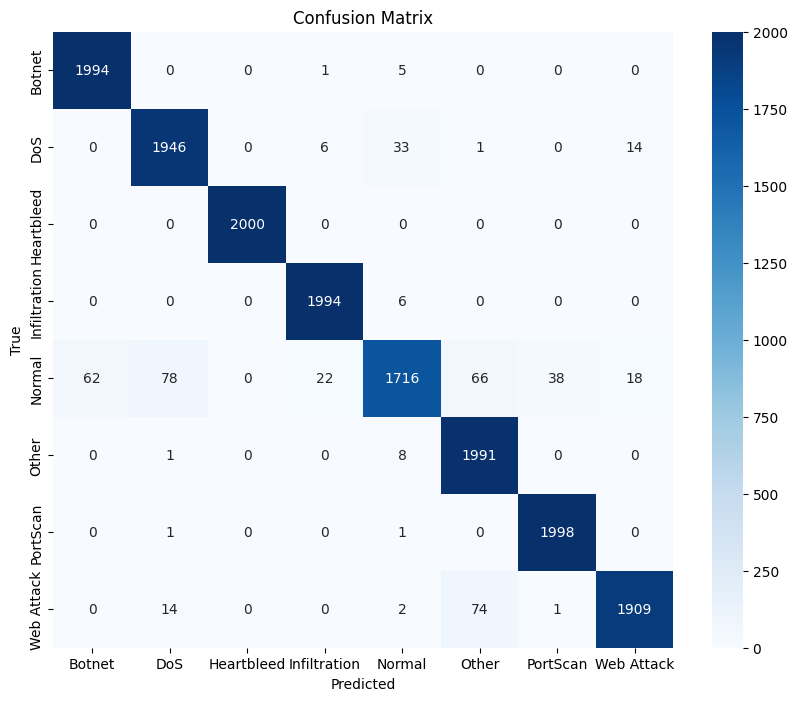

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 9. 성능 평가
# ==========================

# 예측
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# 1) Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labelencoder.classes_))

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [30]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from tqdm import tqdm

print("[시작] 클래스별 Permutation Feature Importance 계산")

# 1. 전체 baseline 성능 계산
X_test_flat = X_test_reshaped.squeeze(axis=2)  # (batch_size, feature_dim)
y_pred_baseline = np.argmax(model.predict(X_test_reshaped, verbose=0), axis=1)
baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')

print(f"[Baseline F1] 전체 데이터 기준: {baseline_f1:.4f}")

# 2. 클래스별 인덱스 나누기
class_indices = {i: np.where(y_test == i)[0] for i in np.unique(y_test)}

[시작] 클래스별 Permutation Feature Importance 계산
[Baseline F1] 전체 데이터 기준: 0.9713


In [31]:
# 3. 클래스별 Feature Importance 계산
feature_importance_per_class = {}
num_features = X_test_flat.shape[1]

for class_label, indices in class_indices.items():
    print(f"\n[진행중] 클래스 {class_label}")

    X_class = X_test_flat[indices]
    y_class = y_test[indices]

    # 클래스별 baseline 성능
    X_class_reshaped = np.expand_dims(X_class, axis=2)
    y_pred_class_baseline = np.argmax(model.predict(X_class_reshaped, verbose=0), axis=1)
    class_baseline_f1 = f1_score(y_class, y_pred_class_baseline, average='macro')

    importances = []

    for feature_idx in tqdm(range(num_features)):
        X_permuted = X_class.copy()
        np.random.shuffle(X_permuted[:, feature_idx])  # Feature 하나만 무작위로 섞음
        X_permuted_reshaped = np.expand_dims(X_permuted, axis=2)

        y_pred_permuted = np.argmax(model.predict(X_permuted_reshaped, verbose=0), axis=1)
        permuted_f1 = f1_score(y_class, y_pred_permuted, average='macro')

        importance = class_baseline_f1 - permuted_f1  # F1-score 하락폭
        importances.append(importance)

    feature_importance_per_class[class_label] = np.array(importances)

    print(f"[완료] 클래스 {class_label} Feature Importance 계산 성공")


[진행중] 클래스 0


100%|██████████| 77/77 [01:39<00:00,  1.29s/it]


[완료] 클래스 0 Feature Importance 계산 성공

[진행중] 클래스 1


100%|██████████| 77/77 [01:37<00:00,  1.27s/it]


[완료] 클래스 1 Feature Importance 계산 성공

[진행중] 클래스 2


100%|██████████| 77/77 [01:38<00:00,  1.28s/it]


[완료] 클래스 2 Feature Importance 계산 성공

[진행중] 클래스 3


100%|██████████| 77/77 [01:39<00:00,  1.30s/it]


[완료] 클래스 3 Feature Importance 계산 성공

[진행중] 클래스 4


100%|██████████| 77/77 [01:42<00:00,  1.33s/it]


[완료] 클래스 4 Feature Importance 계산 성공

[진행중] 클래스 5


100%|██████████| 77/77 [01:41<00:00,  1.32s/it]


[완료] 클래스 5 Feature Importance 계산 성공

[진행중] 클래스 6


100%|██████████| 77/77 [01:41<00:00,  1.32s/it]


[완료] 클래스 6 Feature Importance 계산 성공

[진행중] 클래스 7


100%|██████████| 77/77 [01:39<00:00,  1.29s/it]

[완료] 클래스 7 Feature Importance 계산 성공


In [35]:
# y_test 라벨 종류와 순서 출력
unique_labels = np.unique(y_test)

# 반드시 실행
print("\n[Label 디코딩 매핑 확인]")
for idx, class_name in enumerate(labelencoder.classes_):
    print(f"{idx}: {class_name}")

# 현재 X 데이터의 컬럼 이름 리스트 출력
current_feature_names = X.columns.tolist()

print("[현재 Feature 목록]")
for idx, feature in enumerate(current_feature_names):
    print(f"{idx}: {feature}")




[Label 디코딩 매핑 확인]
0: Botnet
1: DoS
2: Heartbleed
3: Infiltration
4: Normal
5: Other
6: PortScan
7: Web Attack
[현재 Feature 목록]
0: Flow Duration
1: Total Fwd Packets
2: Total Backward Packets
3: Total Length of Fwd Packets
4: Total Length of Bwd Packets
5: Fwd Packet Length Max
6: Fwd Packet Length Min
7: Fwd Packet Length Mean
8: Fwd Packet Length Std
9: Bwd Packet Length Max
10: Bwd Packet Length Min
11: Bwd Packet Length Mean
12: Bwd Packet Length Std
13: Flow Bytes/s
14: Flow Packets/s
15: Flow IAT Mean
16: Flow IAT Std
17: Flow IAT Max
18: Flow IAT Min
19: Fwd IAT Total
20: Fwd IAT Mean
21: Fwd IAT Std
22: Fwd IAT Max
23: Fwd IAT Min
24: Bwd IAT Total
25: Bwd IAT Mean
26: Bwd IAT Std
27: Bwd IAT Max
28: Bwd IAT Min
29: Fwd PSH Flags
30: Bwd PSH Flags
31: Fwd URG Flags
32: Bwd URG Flags
33: Fwd Header Length
34: Bwd Header Length
35: Fwd Packets/s
36: Bwd Packets/s
37: Min Packet Length
38: Max Packet Length
39: Packet Length Mean
40: Packet Length Std
41: Packet Length Variance
42:

In [32]:
# 4. 클래스별 Top-N Feature 출력
TOP_N = 10

for class_label, importance_scores in feature_importance_per_class.items():
    top_features = np.argsort(importance_scores)[::-1][:TOP_N]
    print(f"\n[클래스 {class_label}] 중요도 Top {TOP_N} Feature 인덱스:")
    print(top_features)
    print(f"중요도 점수: {importance_scores[top_features]}")



[클래스 0] 중요도 Top 10 Feature 인덱스:
[46 37 47 36 52  8 38 39 66 50]
중요도 점수: [0.15614328 0.15474659 0.11961205 0.11700422 0.08898012 0.08793462
 0.08780454 0.08760965 0.08683309 0.08599714]

[클래스 1] 중요도 Top 10 Feature 인덱스:
[38 41 51 11 21  9 50 75 26 15]
중요도 점수: [0.07192726 0.06611424 0.05671938 0.05140628 0.04662817 0.04652809
 0.04513838 0.04227821 0.04213519 0.04085824]

[클래스 2] 중요도 Top 10 Feature 인덱스:
[76 75 74 73 72 71 70 69 68 67]
중요도 점수: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[클래스 3] 중요도 Top 10 Feature 인덱스:
[43 24 52 27 19  5 75 71 46 45]
중요도 점수: [0.35218731 0.30682542 0.30634181 0.30586044 0.30485155 0.30416691
 0.30244928 0.26570238 0.26226834 0.26226834]

[클래스 4] 중요도 Top 10 Feature 인덱스:
[50 72  8 52 19 66 22  6 13 14]
중요도 점수: [0.01762432 0.01667368 0.01649239 0.01584376 0.00125156 0.00108351
 0.0007903  0.00053985 0.00037334 0.00033177]

[클래스 5] 중요도 Top 10 Feature 인덱스:
[43 65 36  8 45 35 47 46 51 14]
중요도 점수: [0.18297288 0.1736181  0.1532713  0.15224117 0.1502095  0.13797317
 0.1316247 

In [36]:
# 데이터셋에서 사용된 라벨 출력
print("데이터셋에 포함된 라벨 종류:", np.unique(y))


데이터셋에 포함된 라벨 종류: [0 1 2 3 4 5 6 7]
